# Seminar: Starter Notebook
This notebook helps you quickly use your DataLoading (and optionally DataGraphing) classes in Jupyter.

👉 Flow: Install → Paths → config.py → (optional) Credentials → Loader demos

## 0. inital settings

In [ ]:
%pip install -q pandas numpy plotly kaleido yfinance fredapi ecbdata requests

Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pathlib import Path
from seminar_code.data_loading.data_loader import DataLoading

In [30]:
# Notebook is located at <PROJECT_ROOT>/notebooks/
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve().parent        # one level up from /notebooks
SRC_ROOT = PROJECT_ROOT / "src"                   # parent of 'seminar_code'
sys.path.insert(0, str(SRC_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT, "exists:", SRC_ROOT.exists())


PROJECT_ROOT: C:\Users\josef\Desktop\Seminar
SRC_ROOT: C:\Users\josef\Desktop\Seminar\src exists: True


In [31]:
# --- one-time import (per kernel) ---
from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Instances ready.")

Instances ready.


In [32]:
# --- hot reload after you edited the source files ---
import importlib

import seminar_code.data_loading.data_loader as dl_mod
import seminar_code.data_graphing.data_grapher as dg_mod  # optional

importlib.reload(dl_mod)
importlib.reload(dg_mod)  # optional

from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Modules reloaded and instances created.")


Modules reloaded and instances created.


## 2. load data

In [59]:
# Set dates
START_DATE = pd.Timestamp("2001-01-01")
END_DATE = pd.Timestamp("2025-01-01")

### 2.1. FRED

In [71]:
# --- FRED only: API key -> (ensure) loader -> fetch series ---
FRED_KEY = "4d07b674a78d08a1f75abfdd9a936bc8 "

# write/update secrets/credentials.json next to your project (one level above /notebooks)
PROJECT_ROOT = Path.cwd().resolve().parent   # assumes this notebook is in /notebooks
SECRETS_DIR  = PROJECT_ROOT / "secrets"
SECRETS_DIR.mkdir(parents=True, exist_ok=True)
CRED_FILE = SECRETS_DIR / "credentials.json"
CRED_FILE.write_text(json.dumps({"FRED_API": FRED_KEY, "US_Bureau_of_Labor_Statistics": ""}, indent=2),
                     encoding="utf-8")

92

In [ ]:
# fetch FRED series
fred_map = {"WTI": "DCOILWTICO", "Brent": "DCOILBRENTEU"}
series_dict, meta_dict, lowest = dl.get_fred_data(
    series_dict_mapping=fred_map,
    start_date=START_DATE,
    end_date=END_DATE
)

fred_df = pd.DataFrame(series_dict).astype(float)
fred_df.fillna(method="ffill", inplace=True)

In [85]:
# Check results
print("START_DATE:", START_DATE, "END_DATE:", END_DATE)
print("rows in fred_df:", len(fred_df))
print("index range:", fred_df.index.min(), "->", fred_df.index.max())

START_DATE: 2001-01-01 00:00:00 END_DATE: 2025-01-01 00:00:00
rows in fred_df: 6263
index range: 2001-01-01 00:00:00 -> 2025-01-01 00:00:00


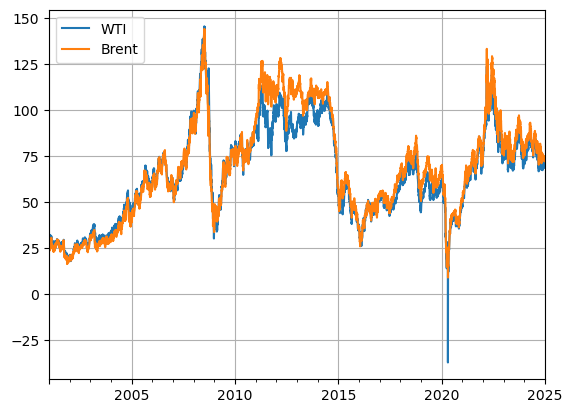

In [88]:
# Simple plot
fred_df['WTI'].plot(label="WTI")
fred_df['Brent'].plot(label="Brent")

plt.legend()
plt.grid()
plt.show()

### 2.2. BIS - Exchange rate basket

In [ ]:
## right now not working - to be fixed later

### 2.3. yahoo Finance

In [83]:
# Yahoo Finance data
yf_df = dl.get_yahoo_data(
    ticker=["CL=F","NG=F"],                # WTI & NatGas futures
    start_date=START_DATE,
    end_date=END_DATE,
    auto_adjust=False,
    interval="1d"
)

[*********************100%***********************]  2 of 2 completed

FUNCTION: get_yahoo_data


## 2. Markov switch application

Source: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html?utm_source=chatgpt.com
- Didn't find this feature in the scikit learn bib, prob. best to condcut our econometric analysis with stats.
- ...

first dummy example

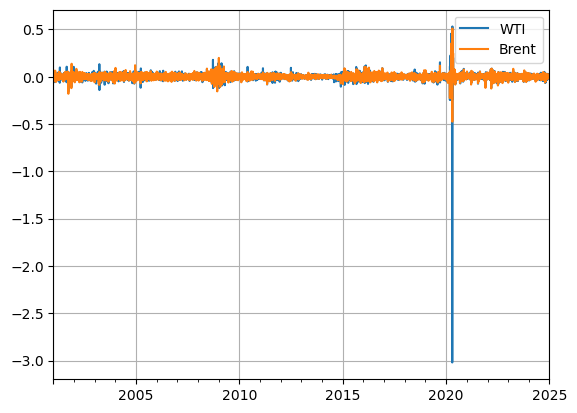

In [ ]:
# Make data stationary
fred_stationary_df = fred_df.pct_change().dropna()

# See if stationary
fred_stationary_df['WTI'].plot(label="WTI")
fred_stationary_df['Brent'].plot(label="Brent")
plt.legend()
plt.grid()
plt.show()

#negative values periode might be problematic for log-returns and the model estimation

In [110]:
# to be continued ...

## 3. Further Econometric analysis

- autocorrelation tests, stationarity, etc.  